This notebook is a simple demo of the (basic) capabilities of this framework.
It is CI-tested to ensure that it works.

In [1]:
%load_ext autoreload
%autoreload 2

Let's say we want to simulate trial to compare the difference between the red and the blue pill on enlightment.
First, we need to define how the data generating process for the model looks like. For this, we subclass the 'Model' class.

A common pattern is to use an ID, e.g., the patient_id, to seed the random generator. This way, if we draw effects from a distribution, this will automatically be reproducible and different between patients.

The 'generate_context' function will return a context, which can help the bandit decide which pill to choose. Here, we choose a simple variable calculated from the length of the current history.

The 'observe_outcome' function then models which outcome will be observed based on the context and the chosen action.

The '\_\_str__' function can be used to change how the model will be named later in the graphics.

In [2]:
import numpy
from adaptive_nof1.models import Model
from adaptive_nof1.basic_types import Outcome

RED_PILL = 1
BLUE_PILL = 2


class PillModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.red_pill_slope = self.rng.normal(0, 1)
        self.patient_id = patient_id

    def generate_context(self, history):
        return {"time_of_the_day": numpy.sin(len(history) / 24 / 3)}

    @property
    def number_of_interventions(self):
        return 2

    def observe_outcome(self, action, context):
        if action["treatment"] == RED_PILL:
            return {"enlightment": context["time_of_the_day"] * self.red_pill_slope}
        else:
            return {"enlightment": self.rng.normal(0.3, 1)}

    def __str__(self):
        return f"PillModel"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## With the data generating model set, we can now set up a simulation study.
Let's say we want to compare the performance between a fixed allocation of red and blue pills and an epsilon-greedy bandit approach.

Let's first define some constants.


In [3]:
# Simulation constants
data_generating_model = lambda patient_id: PillModel(patient_id)

length = 200
number_of_actions = 2
number_of_patients = 10

Now, we create two series of simulations objects. We can use predefined policies.

In [4]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import FixedPolicy, FrequentistEpsilonGreedy, ConstantPolicy

constant_1_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=ConstantPolicy(action=1),
)

constant_2_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=ConstantPolicy(action=2),
)

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedPolicy(),
)

adaptive_series_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FrequentistEpsilonGreedy(outcome_name="enlightment", epsilon=0.2),
)

constant_1_data = constant_1_runner.simulate(length)
constant_2_data = constant_2_runner.simulate(length)
fixed_schedule_data = fixed_schedule_runner.simulate(length)
adaptive_series_data = adaptive_series_runner.simulate(length)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

The framework provides different plots to test the performance. One simple one is the regret over time graph:

<Axes: xlabel='$j$', ylabel='Regret'>

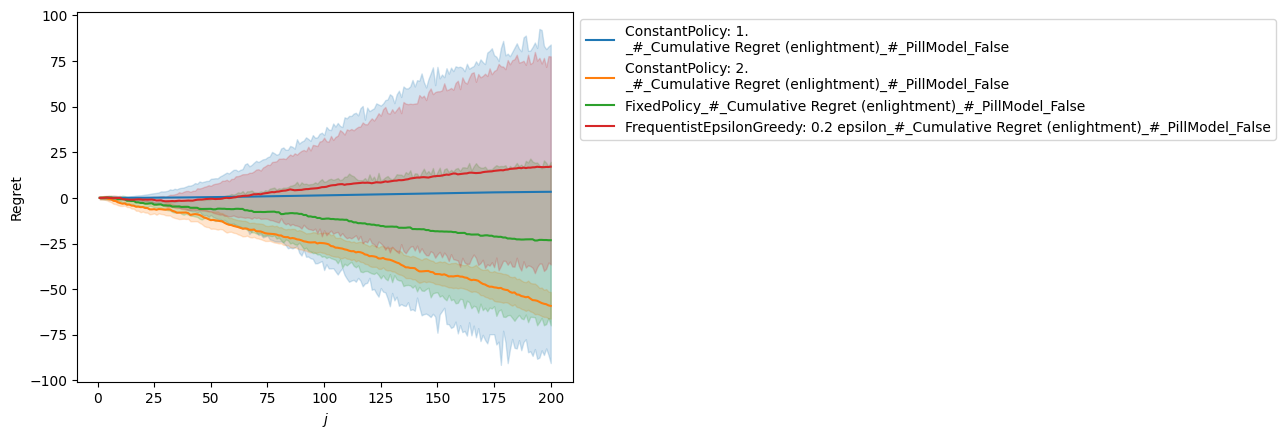

In [11]:
from adaptive_nof1.metrics import CumulativeRegret
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

SeriesOfSimulationsData.plot_lines(
    [constant_1_data, constant_2_data, fixed_schedule_data, adaptive_series_data],
    [CumulativeRegret(outcome_name="enlightment")],
    legend_position=(1, 1),
)

Additionally, one can look at each individual assignment:
If you hover over this graphic, you get detailed information about the assignment, including the counterfactual outcomes if another action would have been chosen.
Try it out yourself!

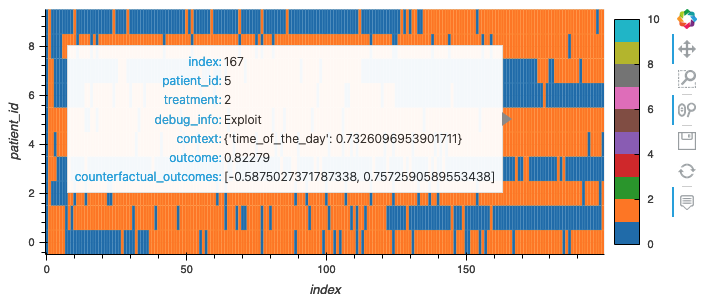

In [13]:
adaptive_series_data.plot_allocations()

:HeatMap   [j,i]   (color_index,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)

There are many more policies, metrics, and models to explore. You can find an overview in the respective '\_\_init__.py' files in the folders, which include the different policies.

In [12]:
adaptive_series_data.simulations[0].history.to_df()

,time_of_the_day,t,patient_id,treatment,enlightment
0,0.000000,0,0,0,0.167895
1,0.013888,1,0,1,0.001746
2,0.027774,2,0,1,0.003492
3,0.041655,3,0,1,0.005237
4,0.055527,4,0,1,0.006981
...,...,...,...,...,...
195,0.419831,195,0,1,0.052785
196,0.407186,196,0,1,0.051196
197,0.394461,197,0,1,0.049596
198,0.381661,198,0,1,0.047986
